In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from sklearn.preprocessing import StandardScaler

In [6]:
data_train_o = pd.read_csv("./data/train.csv")
data_test_o = pd.read_csv("./data/test.csv")



In [7]:
data_train_o.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,ID,TARGET
0,2.0,5.0,5132022,5,13,2022,1100.0,2022000436,2.022000e+09,1.0,...,1.0,2.700000e+01,1.0,1.870000e+02,1.0,1.0,1.0,2.0,0,True
1,9.0,1.0,2282022,2,28,2022,1200.0,2022005381,2.022005e+09,NaN,...,9.0,9.000000e+02,9.0,9.990000e+04,9.0,NaN,NaN,NaN,1,False
2,19.0,1.0,1202022,1,20,2022,1100.0,2022000927,2.022001e+09,1.0,...,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,9.0,2,False
3,39.0,8.0,8122022,8,12,2022,1100.0,2022014408,2.022014e+09,NaN,...,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0,3,False
4,25.0,7.0,7222022,7,22,2022,1200.0,2022010910,2.022011e+09,NaN,...,1.0,1.700000e+01,2.0,4.670000e+02,1.0,NaN,NaN,2.0,4,False


In [8]:
# colomn_to_drop = pd.read_csv("./data/tabledrop.csv")
# ctd = list(set(list(colomn_to_drop["Colonne2"].values)))
ctd = ["FMONTH", "IMONTH", "IYEAR", "DISPCODE", "PVTRESD1", "RENTHOM1", "CERVSCRN", "CRVCLPAP", "USENOW3", "_MAM5023", "_HADCOLN", "_CRCREC2", "_RACEG22", "_LLCPWT", "FLSHTMY3"]
# ctd += list(set())


In [9]:
# Ici on écrit toute les fonctiosn de transformation de fonction
scaler = StandardScaler()

# _STATE
def state(column) :
    return scaler.fit_transform(column)

def weight2(column : pd.DataFrame) :
    
    def pounds_to_kg(value) :
        return value * 0.4535
    
    def transform_meter(value) :
        return value % 1000
    
    column[(column >= 50) & (column <= 776)] = column[(column >= 50) & (column <= 776)].apply(pounds_to_kg)
    column[(column >= 9023) & (column <= 9352)] = column[(column >= 9023) & (column <= 9352)].apply(transform_meter)
    column[column == 7777] = np.nan
    column[column == 9999] = np.nan
    column[column == 777] = np.nan
    column[column == 999] = np.nan
    column[column == 1230] = np.nan
    column.fillna(column.mean(), inplace=True)
    
    
    return column

def height3(column : pd.DataFrame) :
    
    def ft_inches_to_meter(value) :
        feet = value // 100
        inchs = value % 100
        return feet * 0.3048 + inchs * 0.0254
    
    def transform_meter(value) :
        value = value % 1000
        meter = value // 100
        cm = value % 100
        return meter + cm / 100
    
    column[(column >= 200) & (column <= 711)] = column[(column >= 200) & (column <= 711)].apply(ft_inches_to_meter)
    column[(column >= 9061) & (column <= 9998)] = column[(column >= 9061) & (column <= 9998)].apply(transform_meter)
    column[column == 7777] = np.nan
    column[column == 9999] = np.nan
    column.fillna(column.mean(), inplace=True)
    
    
    return column





data_train = data_train_o.copy()
data_test = data_test_o.copy()

result = height3(data_train["HEIGHT3"])
print(result.isna().sum())
print(set(result))



0
{0.9144000000000001, 1.5748, 1.8542000000000003, 1.7526, 1.8288000000000002, 1.8034, 1.6002, 1.5494, 1.714045432413413, 1.6256, 1.7018, 1.5, 1.75, 1.0, 1.25, 1.18, 1.43, 1.6800000000000002, 1.8599999999999999, 1.6099999999999999, 1.9300000000000002, 1.54, 1.79, 1.04, 2.159, 2.2352, 2.54, 1.72, 1.47, 1.778, 1.9304000000000001, 1.65, 1.9, 1.4, 2.0066, 2.0828, 1.4732, 1.397, 1.3208, 1.58, 1.83, 1.2446000000000002, 1.0922, 1.08, 1.51, 1.76, 1.44, 1.69, 1.62, 1.87, 2.05, 1.55, 1.8, 1.3, 1.05, 1.73, 1.48, 1.98, 2.413, 2.3367999999999998, 0.92, 0.9, 0.8636, 1.6600000000000001, 1.5899999999999999, 1.8399999999999999, 2.2606, 2.1082, 2.032, 2.1844, 1.8796000000000002, 1.651, 1.7272, 1.9558000000000002, 1.09, 800.0, 801.0, 1.4986000000000002, 1.4224, 1.52, 1.3462, 1.27, 1.77, 1.1938, 0.9652000000000001, 1.7, 1.45, 1.0414, 1.1176000000000001, 1.2, 1.95, 1.63, 1.88, 1.38, 1.81, 1.56, 1.06, 1.74, 1.49, 1.67, 1.42, 1.17, 1.92, 1.6, 1.85, 1.35, 1.1, 2.1336, 2.286, 2.2098, 2.3622, 1.78, 1.53, 1.03, 

/tmp/ipykernel_1120/3211362811.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[(column >= 200) & (column <= 711)] = column[(column >= 200) & (column <= 711)].apply(ft_inches_to_meter)
/tmp/ipykernel_1120/3211362811.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[(column >= 9061) & (column <= 9998)] = column[(column >= 9061) & (column <= 9998)].apply(transform_meter)
/tmp/ipykernel_1120/3211362811.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [10]:


# data_train["COLGSEX1"] = colgsex1(data_train["COLGSEX1"])
# data_train["COLGSEX1"].isna().sum()


In [ ]:
data_train = data_train_o.copy()
data_test = data_test_o.copy()

def clean_and_fill_data(data_train : pd.DataFrame, data_test : pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame] :
    result_train = pd.DataFrame(data_train["ID"])
    result_test = pd.DataFrame(data_test["ID"])
    
    # result_train["TARGET"] = data_train["TARGET"]
    
    # _STATE
    result_train["_STATE"] = state(data_train[["_STATE"]])
    result_test["_STATE"] = state(data_test[["_STATE"]])
    
    # SEXVAR
    result_train["SEXVAR"] = data_train["SEXVAR"]
    result_test["SEXVAR"] = data_test["SEXVAR"]
    
    # GENHLTH
    value_map = {1: 10,2: 5,3: 0,4: -5,5: -10,7: 0,9: 0,np.nan: 0}
    result_train["GENHLTH"] = data_train["GENHLTH"].replace(value_map)
    result_test["GENHLTH"] = data_test["GENHLTH"].replace(value_map)
    
    # PHYSHLTH
    value_map = {88: 0, 77: 15, 99: 15, np.nan: 15}
    result_train["PHYSHLTH"] = data_train["PHYSHLTH"].replace(value_map)
    result_test["PHYSHLTH"] = data_test["PHYSHLTH"].replace(value_map)
    
    # MENTHLTH
    value_map = {88: 0, 77: 15, 99: 15, np.nan: 15}
    result_train["MENTHLTH"] = data_train["MENTHLTH"].replace(value_map)
    result_test["MENTHLTH"] = data_test["MENTHLTH"].replace(value_map)
    
    # POORHLTH
    value_map = {88: 0, 77: 15, 99: 15, np.nan: 15}
    result_train["POORHLTH"] = data_train["POORHLTH"].replace(value_map)
    result_test["POORHLTH"] = data_test["POORHLTH"].replace(value_map)
    
    # MEDCOST1
    value_map = {7 : 1, 9 : 1, np.nan: 1}
    result_train["MEDCOST1"] = data_train["MEDCOST1"].replace(value_map)
    result_test["MEDCOST1"] = data_test["MEDCOST1"].replace(value_map)
    
    # CHECKUP1
    value_map = {7 : 3, 8 : 4, 9 : 3, np.nan: 3}
    result_train["CHECKUP1"] = data_train["CHECKUP1"].replace(value_map)
    result_test["CHECKUP1"] = data_test["CHECKUP1"].replace(value_map)
    
    # EXERANY2
    value_map = {7 : 2, 9 : 2, np.nan: 2}
    result_train["EXERANY2"] = data_train["EXERANY2"].replace(value_map)
    result_test["EXERANY2"] = data_test["EXERANY2"].replace(value_map)
    
    # SLEPTIM1
    value_map = {77 : 7, 99 : 7, np.nan: 7}
    result_train["SLEPTIM1"] = data_train["SLEPTIM1"].replace(value_map)
    result_test["SLEPTIM1"] = data_test["SLEPTIM1"].replace(value_map)
    result_test["SLEPTIM1"] = state(result_test[["SLEPTIM1"]])
    
    # RMVTETH4
    value_map = {7 : 1, 8 : 0, 9 : 1, np.nan: 1}
    result_train["RMVTETH4"] = data_train["RMVTETH4"].replace(value_map)
    result_test["RMVTETH4"] = data_test["RMVTETH4"].replace(value_map)
    
    # CVDINFR4
    # value_map = {7 : 2, 9 : 2, np.nan: 2}
    # result_train["CVDINFR4"] = data_train["CVDINFR4"].replace(value_map)
    # result_test["CVDINFR4"] = data_test["CVDINFR4"].replace(value_map)
    
    # ASTHNOW
    value_map = {7 : 2, 9 : 2, np.nan: 2}
    result_train["ASTHNOW"] = data_train["ASTHNOW"].replace(value_map)
    result_test["ASTHNOW"] = data_test["ASTHNOW"].replace(value_map)
    
    # WEIGHT2
    result_train["WTKG3"] = weight2(data_train["WEIGHT2"])
    result_test["WTKG3"] = weight2(data_test["WEIGHT2"])
    
    # HTM4
    result_train["HTM4"] = height3(data_train["HEIGHT3"])
    result_test["HTM4"] = height3(data_test["HEIGHT3"])

    # _BMI5
    result_train["_BMI5"] = result_train["WTKG3"]/(result_train["HTM4"]*result_train["HTM4"])
    result_test["_BMI5"] = result_test["WTKG3"]/(result_test["HTM4"]*result_test["HTM4"])
    
    # LCSNUMCG
    value_map = {777 : 150, 999 : 0, np.nan: 0}
    result_train["LCSNUMCG"] = data_train["LCSNUMCG"].replace(value_map)
    result_test["LCSNUMCG"] = data_test["LCSNUMCG"].replace(value_map)
    
    # _AGE80
    # value_map = {777 : 150, 999 : 0, np.nan: 0}
    result_train["_AGE80"] = data_train["_AGE80"]
    result_test["_AGE80"] = data_test["_AGE80"]
    
    # result_train["ID"] = data_train["ID"]
    # result_test["ID"] = data_test["ID"]
    result_train["TARGET"] = data_train["TARGET"]
    
    
    
    return result_train, result_test

data_train_clean, data_test_clean = clean_and_fill_data(data_train=data_train,
                                                        data_test=data_test)

data_train_clean.isna().sum()
# set(data_train_clean["WTKG3"][data_train_clean["WTKG3"].notna()])

/tmp/ipykernel_1120/3211362811.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[(column >= 50) & (column <= 776)] = column[(column >= 50) & (column <= 776)].apply(pounds_to_kg)
/tmp/ipykernel_1120/3211362811.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[(column >= 9023) & (column <= 9352)] = column[(column >= 9023) & (column <= 9352)].apply(transform_meter)
/tmp/ipykernel_1120/3211362811.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

ID          0
_STATE      0
SEXVAR      0
GENHLTH     0
PHYSHLTH    0
MENTHLTH    0
POORHLTH    0
MEDCOST1    0
CHECKUP1    0
EXERANY2    0
SLEPTIM1    0
RMVTETH4    0
ASTHNOW     0
WTKG3       0
HTM4        0
_BMI5       0
LCSNUMCG    0
_AGE80      0
TARGET      0
dtype: int64

In [ ]:
data_train = data_test_o.copy()
data_test = data_test_o.copy()


def clean_and_fill_data(data_train : pd.DataFrame, data_test : pd.DataFrame, column_to_drop) -> Tuple[pd.DataFrame, pd.DataFrame] :
    # ici on va drop les colonnes
    
    # Fin du dropage des colonnes
    
    indexs_to_fill_with_0 = []
    
    missing_values = data_train.isnull().sum()
    missing_values_treshold = missing_values[missing_values >= 1]

    
    for index in missing_values_treshold.index :
        possible_value = set(data_train[index].dropna())
        condition_categoriel = (len(possible_value) <= 10) # si on a moins de 100 réponse disponible on considère que c'est catégorielle. Donc on remplace par 0 au vue des questions.
        condition_categoriel = condition_categoriel or 999 in possible_value # Dans certaine question 999 c'est refused de répondre
        condition_categoriel = condition_categoriel or 777 in possible_value
        condition_categoriel = condition_categoriel or 999999 in possible_value
        condition_categoriel = condition_categoriel or 99 in possible_value
        
        if condition_categoriel :
            indexs_to_fill_with_0.append(index)

    missing_values = data_test.isnull().sum()
    missing_values_treshold = missing_values[missing_values >= 1]
    for index in missing_values_treshold.index :
        possible_value = set(data_test[index].dropna())
        condition_categoriel = (len(possible_value) <= 10) # si on a moins de 100 réponse disponible on considère que c'est catégorielle. Donc on remplace par 0 au vue des questions.
        condition_categoriel = condition_categoriel or 999 in possible_value # Dans certaine question 999 c'est refused de répondre
        condition_categoriel = condition_categoriel or 777 in possible_value
        condition_categoriel = condition_categoriel or 999999 in possible_value
        condition_categoriel = condition_categoriel or 99 in possible_value

        if condition_categoriel :
            indexs_to_fill_with_0.append(index)
        
    for index in indexs_to_fill_with_0 :
        data_train[index] = data_train[index].fillna(0)
        data_test[index] = data_test[index].fillna(0)
        
        
        
        
    
    
    indexs_to_fill_with_mean = ["_CLLCPWT", "WTKG3", "_BMI5"]
    for index in indexs_to_fill_with_mean :
        data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        data_train[index] = data_train[index].fillna(data_train[index].dropna().mean())
        data_test[index] = data_test[index].fillna(data_test[index].dropna().mean())
    
    
    
    # On modifier la taille ici
    data_train = data_train.drop("HEIGHT3", axis=1)
    data_test = data_test.drop("HEIGHT3", axis=1)
    
    data_train["_PACKDAY"] = data_train["LCSNUMCG"]/20
    data_test["_PACKDAY"] = data_test["LCSNUMCG"]/20
    
    data_train["_PACKYRS"] = round(data_train["_YRSSMOK"]*data_train["_PACKDAY"])
    data_test["_PACKYRS"] = round(data_test["_YRSSMOK"]*data_test["_PACKDAY"])
    

    value_map = {
    1: 10,
    2: 5,
    3: 0,
    4: -5,
    5: -10,
    7: 0,
    9: 0,
    np.nan: 0  # Handle NaN explicitly
    }
    
    data_train["GENHLTH"] = data_train["GENHLTH"].replace(value_map)
    data_test["GENHLTH"] = data_test["GENHLTH"].replace(value_map) 

    value_map = {
        88 : 0,
        99: 0,
        77 : 15,
        np.nan: 0  # Handle NaN explicitly
    }
    data_train["PHYSHLTH"] = data_train["PHYSHLTH"].replace(value_map)
    data_test["PHYSHLTH"] = data_test["PHYSHLTH"].replace(value_map) 

    value_map = {
        88 : 0,
        99: 0,
        77 : 15,
        np.nan: 0  # Handle NaN explicitly
    }
    data_train["MENTHLTH"] = data_train["MENTHLTH"].replace(value_map)
    data_test["MENTHLTH"] = data_test["MENTHLTH"].replace(value_map)


    # data_train["_BMI5"] = (data_train["WTKG3"]/(data_train["HTM4"]*data_train["HTM4"])).apply(lambda x : max(1,x))
    # data_test["_BMI5"] = (data_test["WTKG3"]/(data_test["HTM4"]*data_test["HTM4"])).apply(lambda x : max(1,x))

    
    
    for column in column_to_drop :
        data_train = data_train.drop(column, axis=1)
        data_test = data_test.drop(column, axis=1)
        
    
    data_test.fillna(0)
    data_train.fillna(0)
    
    return data_train, data_test


    
data_train_clean, data_test_clean = clean_and_fill_data(data_train=data_train,
                                                        data_test=data_test,
                                                        column_to_drop=ctd)

# data_train_clean.to_csv("./data/train1.csv")
# data_test_clean.to_csv("./data/test1.csv")

print(np.isinf(data_train_clean).sum().sum())
print(np.isinf(data_test_clean).sum().sum())

print(data_train_clean.isnull().sum().sum())
print(data_test_clean.isnull().sum().sum())
data_test_clean.isnull().sum()[data_test_clean.isnull().sum() != 0]



True
0
0
215846
215846


_DUALCOR    48120
HTIN4        5671
HTM4         4988
_YRSSMOK    50041
_PACKYRS    50041
_YRSQUIT    56984
DROCDY4_        1
dtype: int64

In [12]:

data_train_clean = data_train_clean.drop("ID", axis=1)
data_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    225000 non-null  float64
 1   SEXVAR    225000 non-null  float64
 2   GENHLTH   225000 non-null  float64
 3   PHYSHLTH  225000 non-null  float64
 4   MENTHLTH  225000 non-null  float64
 5   POORHLTH  225000 non-null  float64
 6   MEDCOST1  225000 non-null  float64
 7   CHECKUP1  225000 non-null  float64
 8   EXERANY2  225000 non-null  float64
 9   SLEPTIM1  225000 non-null  float64
 10  RMVTETH4  225000 non-null  float64
 11  ASTHNOW   225000 non-null  float64
 12  WTKG3     225000 non-null  float64
 13  HTM4      225000 non-null  float64
 14  _BMI5     225000 non-null  float64
 15  LCSNUMCG  225000 non-null  float64
 16  _AGE80    225000 non-null  float64
 17  TARGET    225000 non-null  bool   
dtypes: bool(1), float64(17)
memory usage: 29.4 MB


In [ ]:
data_train = data_train_o.copy()
data_test = data_test_o.copy()
data_train_clean = data_train.fillna(data_train.mean())
data_test_clean = data_test.fillna(data_test.mean())


675000

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = data_train_clean.iloc[:, :-1]  # All columns except the last one
y = data_train_clean.iloc[:, -1] 
print(X.shape)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X, y)

(225000, 17)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [13]:

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = data_train_clean.iloc[:, :-1]  # All columns except the last one
y = data_train_clean.iloc[:, -1]   # The last column is the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


/home/bolympio/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:01:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

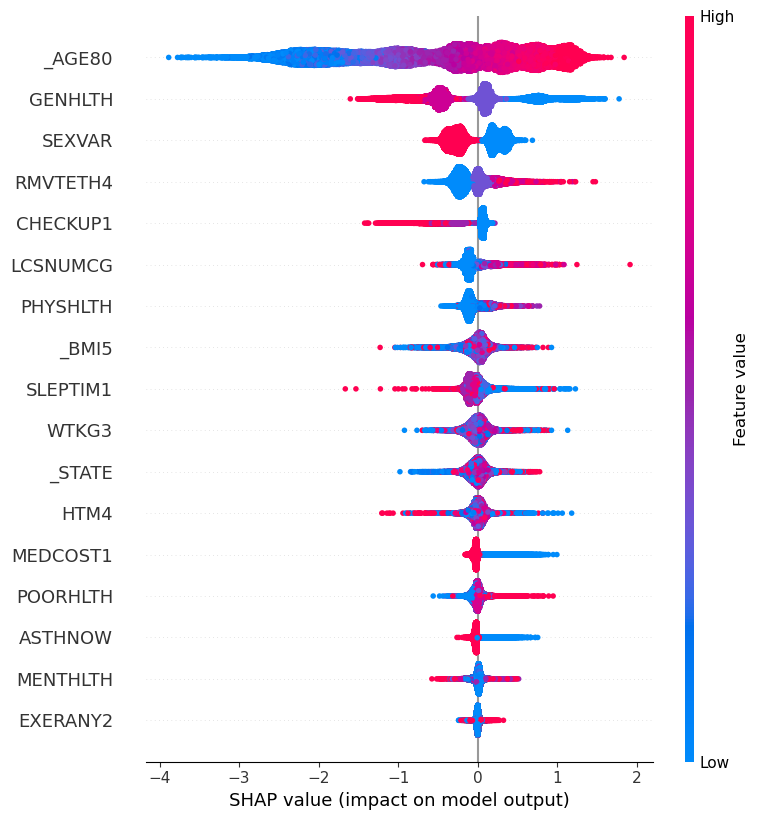

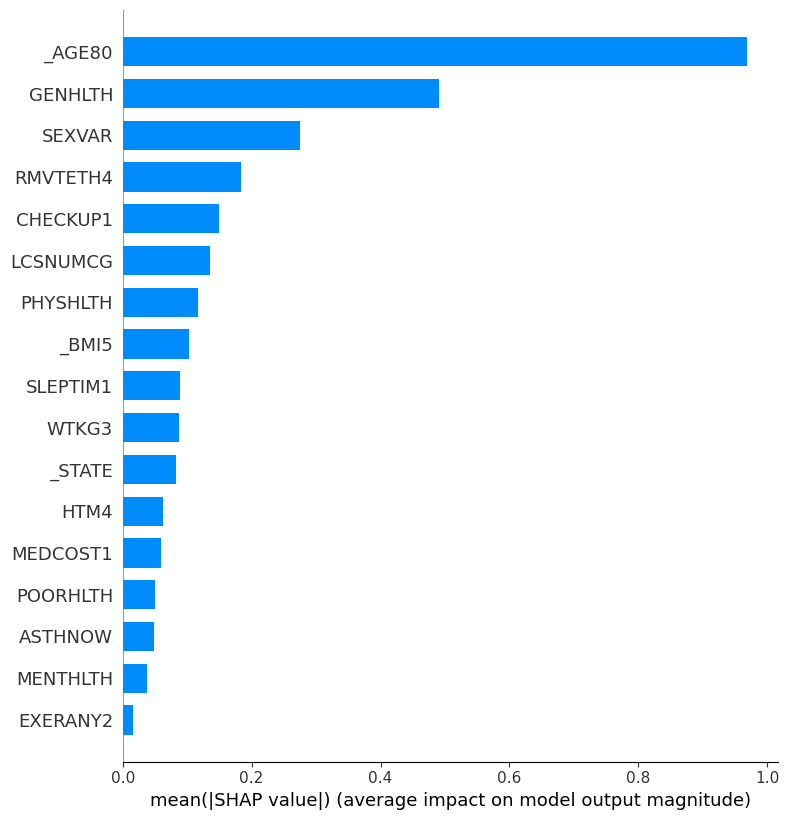

In [14]:
import shap

# SHAP Integration
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

# Bar plot for average feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [24]:
sample = data_test_clean # .sample(n=75000, random_state=42)

In [25]:
sample.head()

,ID,_STATE,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,MEDCOST1,CHECKUP1,EXERANY2,SLEPTIM1,RMVTETH4,ASTHNOW,WTKG3,HTM4,_BMI5,LCSNUMCG,_AGE80
0,225000,-1.444705,2.0,10.0,0.0,0.0,15.0,2.0,1.0,2.0,-0.679527,1.0,2.0,74.8275,1.7272,25.082798,0.0,64.0
1,225001,1.611201,1.0,0.0,0.0,15.0,15.0,2.0,1.0,2.0,-0.008261,1.0,1.0,172.3300,1.8034,52.987906,20.0,40.0
2,225002,-0.889086,1.0,-5.0,2.0,30.0,30.0,2.0,1.0,1.0,-2.022058,1.0,2.0,104.3050,1.8796,29.523936,0.0,37.0
3,225003,1.148185,2.0,-5.0,0.0,0.0,15.0,1.0,3.0,1.0,-0.008261,0.0,2.0,76.1880,1.5748,30.721029,0.0,60.0
4,225004,-1.815118,1.0,5.0,30.0,0.0,0.0,2.0,1.0,1.0,-2.022058,0.0,2.0,124.7125,1.9304,33.466891,0.0,78.0


In [26]:
id_pred = sample.iloc[:, 0]
# sample = 
# print(np.shape(sample))
y_pred = rf_clf.predict(sample.iloc[:, 1:])
print(y_pred)

[False False False ... False False False]


In [27]:
submit = pd.DataFrame(
    {
        "ID" : id_pred,
        "pred" : y_pred
    }
)

submit.to_csv("./data/submit.csv", index=False)